In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.model_selection import KFold

pd.set_option('display.max_columns', 500)

In [12]:
def transform_features(df, percent_missing=0.05):
    num_missing = df.isnull().sum()
    drop_missing_cols = num_missing[(num_missing > len(df)*percent_missing)].sort_values()
    df = df.drop(drop_missing_cols.index, axis=1)
    
    text_mv_counts = df.select_dtypes(include=['object']).isnull().sum().sort_values(
        ascending=False)
    drop_missing_cols_2 = text_mv_counts[text_mv_counts > 0]
    df = df.drop(drop_missing_cols_2.index, axis=1)
    
    num_missing = df.select_dtypes(include=['int', 'float']).isnull().sum()
    fixable_numeric_cols = num_missing[(num_missing < len(df)*percent_missing) & 
                                       (num_missing > 0)].sort_values()
    replacement_values_dict = df[fixable_numeric_cols.index].mode().to_dict(
        orient='records')[0]
    df = df.fillna(replacement_values_dict)
    
    years_sold = df['Yr Sold'] - df['Year Built']
    years_since_remod = df['Yr Sold'] - df['Year Remod/Add']
    df['Years Before Sale'] = years_sold
    df['Years Since Remod'] = years_since_remod
    df = df.drop([1702, 2180, 2181], axis=0)
    df = df.drop(["PID", "Order", "Mo Sold", "Sale Condition", "Sale Type", "Year Built", 
                  "Year Remod/Add"], axis=1)
    
    return df

In [24]:
def select_features(df, coeff_threshold=0.4, uniq_threshold=10):
    numerical_df = df.select_dtypes(include=['integer', 'float'])
    abs_corr_coeffs = numerical_df.corr()['SalePrice'].abs().sort_values()
    df = df.drop(abs_corr_coeffs[abs_corr_coeffs < coeff_threshold].index, axis=1)
    
    nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour",
                        "Lot Config", "Neighborhood", "Condition 1", "Condition 2", 
                        "Bldg Type", "House Style", "Roof Style", "Roof Matl","Exterior 1st",
                        "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", 
                        "Central Air", "Garage Type","Misc Feature", "Sale Type", 
                        "Sale Condition"]
    
    transform_cat_cols = []
    for col in nominal_features:
        if col in df.columns:
            transform_cat_cols.append(col)
            
    uniqueness_counts = df[transform_cat_cols].apply(lambda col: len(col.value_counts())).sort_values()
    drop_nonuniq_cols = uniqueness_counts[uniqueness_counts > uniq_threshold].index
    df = df.drop(drop_nonuniq_cols, axis=1)
    
    text_cols = df.select_dtypes(include=['object'])
    for col in text_cols:
        df[col] = df[col].astype('category')
    df = pd.concat([df, pd.get_dummies(df.select_dtypes(include=['category']))], axis=1)
    
    return df

In [27]:
def train_and_test(df, k=0):
    numeric_df = df.select_dtypes(include=['integer', 'float'])
    features = numeric_df.columns.drop("SalePrice")
    lr = linear_model.LinearRegression()
    
    if k == 0:
        train = df[:1460]
        test = df[1460:]
        
        lr.fit(train[features], train["SalePrice"])
        predictions = lr.predict(test[features])
        
        mse = mean_squared_error(test["SalePrice"], predictions)
        rmse = np.sqrt(mse)
        
        return rmse
    
    if k == 1:
        shuffled_df = df.sample(frac=1, )
        train = df[:1460]
        test = df[1460:]
        
        lr.fit(train[features], train["SalePrice"])
        predictions_one = lr.predict(test[features])
        
        mse_one = mean_squared_error(test["SalePrice"], predictions_one)
        rmse_one = np.sqrt(mse_one)
        
        lr.fit(test[features], test["SalePrice"])
        predictions_two = lr.predict(train[features])
        
        mse_two = mean_squared_error(train["SalePrice"], predictions_two)
        rmse_two = np.sqrt(mse_two)
        
        avg_rmse = np.mean([rmse_one, rmse_two])
        print(rmse_one)
        print(rmse_two)
        
        return avg_rmse
    
    else:
        kf = KFold(n_splits=k, shuffle=True)
        rmse_values = []
        
        for train_index, test_index, in kf.split(df):
            train = df.iloc[train_index]
            test = df.iloc[test_index]
            
            lr.fit(train[features], train["SalePrice"])
            predictions = lr.predict(test[features])
            
            mse = mean_squared_error(test["SalePrice"], predictions)
            rmse = np.sqrt(mse)
            rmse_values.append(rmse)
        
        print(rmse_values)
        avg_rmse = np.mean(rmse_values)
        
        return avg_rmse

33367.28718340389
27155.138484825155
[32344.985260564754, 27579.97406760893]
[24915.906442179672, 27394.324448648247, 34862.19668213704]
[28296.590074559026, 27350.99061416504, 36035.967845478925, 25798.74351078044]
[28651.754365959707, 24827.4918383486, 37991.42043865456, 26835.785051779687, 27468.76946153168]
[26274.340998936674, 27273.94603290403, 39880.217320083546, 27024.99884678219, 27825.690757628756, 25232.057674691376]
[27266.401558427366, 24221.546667415507, 42513.95956135978, 27386.785642532228, 27291.469860699304, 27681.51279061344, 25079.534854958543]
[26097.928856331015, 32420.5226768725, 25917.061478950545, 25396.910078397774, 22922.168649612446, 42686.277581233866, 26911.111031767745, 25551.286786899807]
[27778.726838835213, 47346.95703837165, 26667.157200573267, 28889.58942204355, 26478.781392546152, 24843.524861889837, 24654.01154655359, 23690.896158674637, 26663.623144491405]


Text(0, 0.5, 'RMSE')

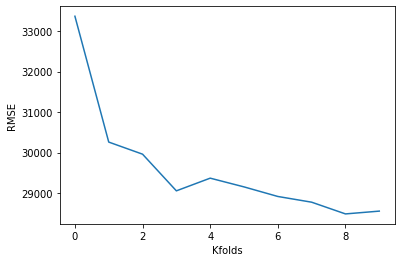

In [29]:
data = pd.read_csv("AmesHousing.tsv", delimiter='\t')

transformed_data = transform_features(data)
final_data = select_features(transformed_data)

results = []
for i in range(10):
    result = train_and_test(final_data, k=i)
    results.append(result)
    
x = [i for i in range(10)]
y = results 
plt.plot(x, y)
plt.xlabel('Kfolds')
plt.ylabel('RMSE')

In [ ]:
transformed_data